# LeNet5

- **Student ID** : 2020111996
- **Name** : 김태겸

---

0. Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import random

---

1. LeNet-5 Model Definition

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 6, 5),    # 1×32×32 -> 6×28×28
            nn.Tanh(),
            nn.AvgPool2d(2, 2),    # 6×14×14
            nn.Conv2d(6, 16, 5),   # 16×10×10
            nn.Tanh(),
            nn.AvgPool2d(2, 2),    # 16×5×5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

2. Custom Dataset for POC_Dataset

In [ ]:
class POCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.class_names = ["Chorionic_villi", "Decidual_tissue", "Hemorrhage", "Trophoblastic_tissue"]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}

        self.image_paths = []
        self.labels = []

        for cls in self.class_names:
            cls_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.lower().endswith(".jpg"):
                    self.image_paths.append(os.path.join(cls_folder, fname))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # 흑백
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)

3. Transformations

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

4. Load Dataset + DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path = "/content/drive/MyDrive/POC_Dataset/Training"
test_path = "/content/drive/MyDrive/POC_Dataset/Testing"

train_dataset = POCDataset(train_path, transform=transform)
test_dataset = POCDataset(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

5. Model / Loss Function / Optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

6. Training/Evaluation function

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    correct = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    avg_loss = total_loss / len(loader)
    acc = 100.0 * correct / len(loader.dataset)
    return avg_loss, acc

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    avg_loss = total_loss / len(loader)
    acc = 100.0 * correct / len(loader.dataset)
    return avg_loss, acc


7. Training Loop + Record Saving

In [ ]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

EPOCHS = 10
for epoch in range(EPOCHS):
    tl, ta = train_one_epoch(model, train_loader)
    vl, va = evaluate(model, test_loader)
    train_losses.append(tl)
    train_accs.append(ta)
    test_losses.append(vl)
    test_accs.append(va)
    print(f"[Epoch {epoch+1}] Train Loss: {tl:.4f}, Train Acc: {ta:.2f}% | Test Loss: {vl:.4f}, Test Acc: {va:.2f}%")

[Epoch 1] Train Loss: 1.3595, Train Acc: 32.68% | Test Loss: 1.3858, Test Acc: 30.11%
[Epoch 2] Train Loss: 1.3542, Train Acc: 33.57% | Test Loss: 1.3968, Test Acc: 26.01%
[Epoch 3] Train Loss: 1.3479, Train Acc: 35.19% | Test Loss: 1.4027, Test Acc: 28.06%
[Epoch 4] Train Loss: 1.3497, Train Acc: 34.20% | Test Loss: 1.4000, Test Acc: 28.86%
[Epoch 5] Train Loss: 1.3431, Train Acc: 34.97% | Test Loss: 1.3880, Test Acc: 28.52%
[Epoch 6] Train Loss: 1.3428, Train Acc: 34.49% | Test Loss: 1.4013, Test Acc: 28.72%
[Epoch 7] Train Loss: 1.3403, Train Acc: 34.25% | Test Loss: 1.4034, Test Acc: 27.80%
[Epoch 8] Train Loss: 1.3329, Train Acc: 34.27% | Test Loss: 1.4059, Test Acc: 28.59%
[Epoch 9] Train Loss: 1.3296, Train Acc: 34.30% | Test Loss: 1.3968, Test Acc: 28.46%
[Epoch 10] Train Loss: 1.3267, Train Acc: 34.25% | Test Loss: 1.4049, Test Acc: 27.40%


8. Accuracy / Loss graph

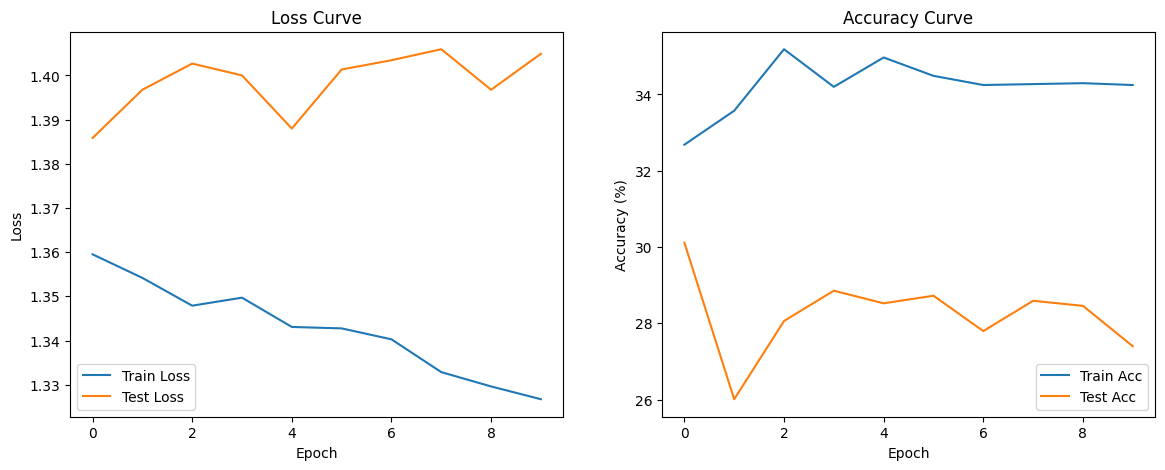

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

9. Precision / Recall / F1-score + Confusion Matrix


=== Classification Report ===
                      precision    recall  f1-score   support

     Chorionic_villi       0.25      0.58      0.35       390
     Decidual_tissue       0.19      0.13      0.15       349
          Hemorrhage       0.33      0.24      0.28       421
Trophoblastic_tissue       0.55      0.12      0.20       351

            accuracy                           0.27      1511
           macro avg       0.33      0.27      0.24      1511
        weighted avg       0.33      0.27      0.25      1511

Macro Precision: 0.32989959102036304
Macro Recall   : 0.2669222221000631
Macro F1-score : 0.24471086844935233


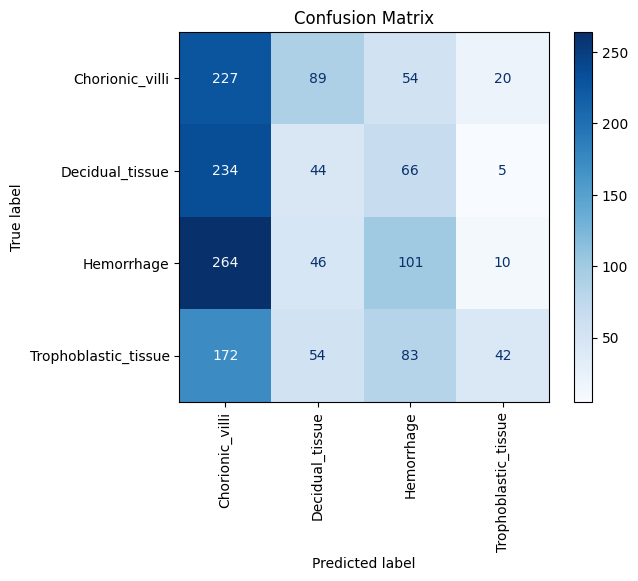

In [ ]:
class_names = ["Chorionic_villi", "Decidual_tissue", "Hemorrhage", "Trophoblastic_tissue"]

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

print("Macro Precision:", precision_score(all_labels, all_preds, average='macro', zero_division=0))
print("Macro Recall   :", recall_score(all_labels, all_preds, average='macro', zero_division=0))
print("Macro F1-score :", f1_score(all_labels, all_preds, average='macro', zero_division=0))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()


10. Visualizing sample image predictions

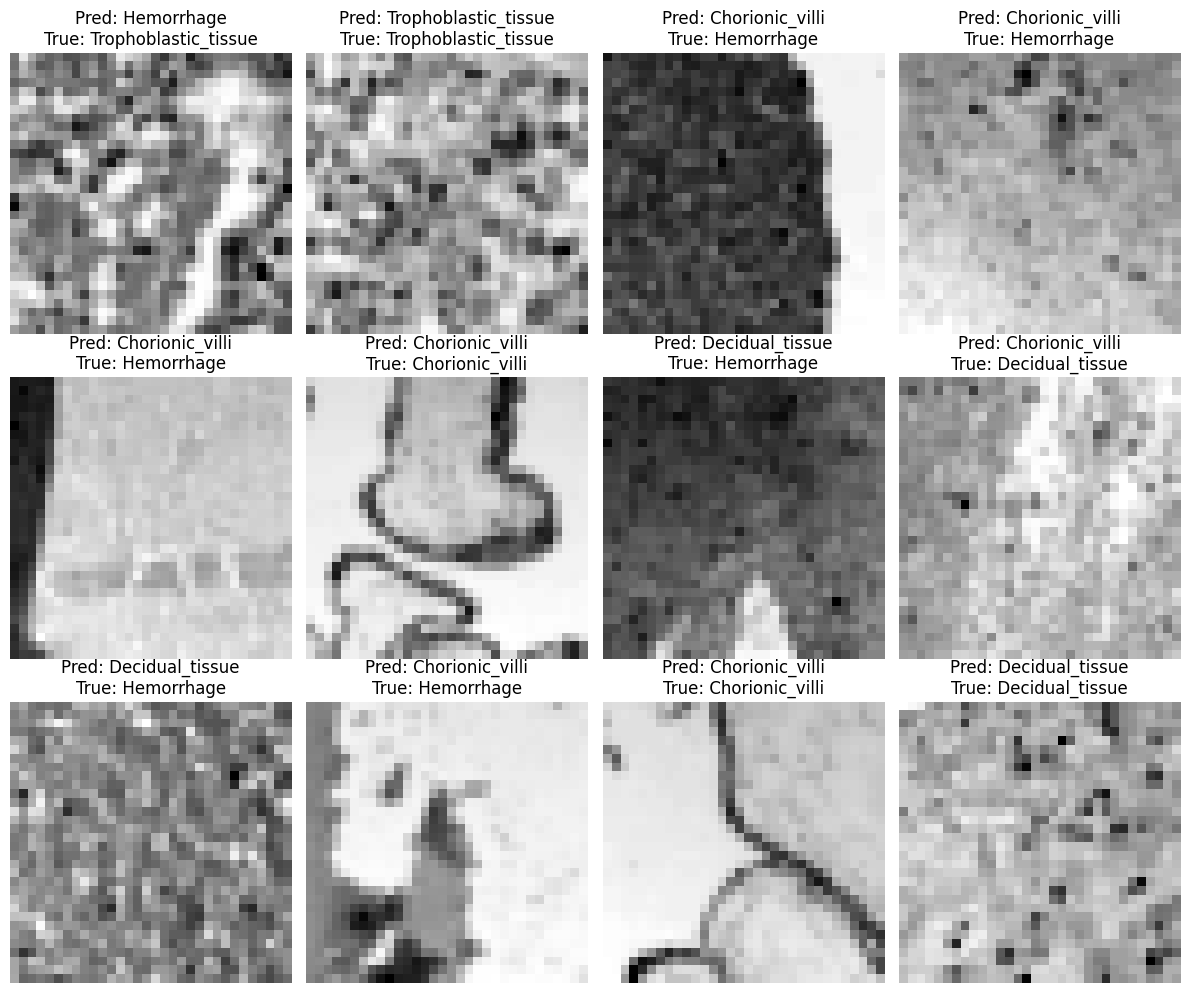

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(12):
    idx = random.randint(0, len(test_dataset)-1)
    img, label = test_dataset[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    plt.subplot(3, 4, i+1)
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

11. Save model

In [ ]:
save_path = "/content/drive/MyDrive/lenet5_poc_model.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to", save_path)

Model saved to /content/drive/MyDrive/lenet5_poc_model.pth
